<a href="https://colab.research.google.com/github/ElZho/Translate-from-old-russian-language.Seq2seq-model./blob/main/Seq2Seq_translation_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [3]:
import unicodedata
import string
import re
import random

In [4]:
import time
import math

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [6]:
import os
from pathlib import Path
import sys

In [46]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r ./drive/My\ Drive/NLP_translation/* . 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from preprocessing_baseline import prepareData, readLangs, tensorsFromPair, tensorFromSentence

In [8]:
MAX_LENGTH=25
SOS_token = 0
EOS_token = 1

In [9]:
from model_baseline import EncoderRNN, AttnDecoderRNN

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
path='./old_slav.txt'

Upload data and make preprocessing

In [47]:
train_input_lang, train_output_lang, train_pairs, test_input_lang,\
           test_output_lang, test_pairs = prepareData('old_rus', 'new_rus', path, MAX_LENGTH, True)
print(random.choice(train_pairs))

Reading lines...
Read 159 sentence pairs train
Read 69 sentence pairs test
Trimmed to 159 sentence train pairs
Trimmed to 69 sentence test pairs
Counting words...
Counted words train:
old_rus 767
new_rus 728
Counted words test:
old_rus 369
new_rus 347
['повѣда намъ отьць васиянъ ', 'вот что рассказал нам отец вассиан ']


Check len train pair

In [60]:
len_train=([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in train_pairs)
max(len_train)

[24, 24]

Check len test pair

In [59]:
len_test=([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in test_pairs)
max(len_test)

[24, 25]

Let's make a length of sentences analysis.

In [16]:
def len_pair(pair):
  len_0=len(pair[0].split(' '))
  len_1=len(pair[1].split(' '))
  return len_0, len_1
len_train_old=[] 
len_train_new=[] 
for pair in train_pairs:  
  old, new=len_pair(pair)
  len_train_old.append(old)
  len_train_new.append(new)

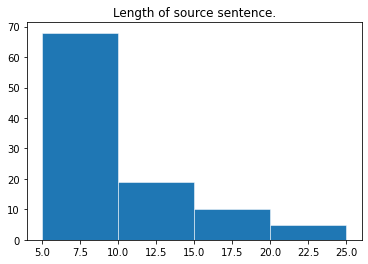

In [61]:
fig, ax = plt.subplots()
ax.hist(len_train_old, bins=[5, 10, 15, 20, 25], linewidth=0.5, edgecolor="white")
plt.title('Length of source sentence.');



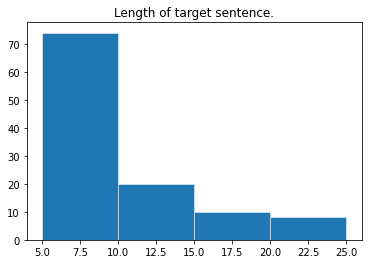

In [62]:
fig, ax = plt.subplots()
ax.hist(len_train_new, bins=[5, 10, 15, 20, 25], linewidth=0.5, edgecolor="white")
plt.title('Length of target sentence.');

Train with teacher_forcing

In [12]:
#Set teacher_forcing_ratio. 
teacher_forcing_ratio = 0.5 #that mean, that 50% decoder imputs going to be real target sentence.

#Create a train loop
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    encoder_hidden = encoder.initHidden()#create encoder hidden layer
    #reset to zero optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    #set length of input and target. The sentence were not padded, so the length will be different each time
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device) #tensor, where we will keep encoder outputs

    loss = 0 #reset loss to zero
    # encoder loop
    for ei in range(input_length):
        
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device=device)#create decoder input for first loop   
    
    decoder_hidden = encoder_hidden #pass encoder hidden layer to decoder

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False #randomly choose to use teacher forcing or use decoder output as next input
    #teacher forcing decoder loop
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)            
            loss += criterion(decoder_output, target_tensor[di]) #calculate loss
            decoder_input = target_tensor[di]  # Teacher forcing
           
    # decoder loop without teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1) #take max value and its index
            decoder_input = topi.squeeze().detach()  # detach from history as input
            
            loss += criterion(decoder_output, target_tensor[di]) #calculate loss
            
            if decoder_input.item() == EOS_token: #cheak if end of sentence
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length, encoder_hidden #pass encoder hidden layer to validation

Validation loop.

In [13]:
def valid(input_tensor, target_tensor, encoder, decoder, encoder_hidden, criterion, max_length=MAX_LENGTH):
    #encoder_hidden = encoder.initHidden()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    with torch.no_grad(): # no backpropagation
      encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
      loss = 0 #reset loss to zero
      # encoder loop
      for ei in range(input_length):
          
          encoder_output, encoder_hidden = encoder(
              input_tensor[ei], encoder_hidden)
          encoder_outputs[ei] = encoder_output[0, 0]

          decoder_input = torch.tensor([[SOS_token]], device=device) #create decoder input for first loop  
          decoder_hidden = encoder_hidden #pass encoder hidden layer to decoder
    
      # there is no teacher forcing in validation loop
      for di in range(target_length):
           
          decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
          topv, topi = decoder_output.topk(1) #take max value and its index
          decoder_input = topi.squeeze().detach()  # detach from history as input
          
          loss += criterion(decoder_output, target_tensor[di]) #calculate loss
          
          if decoder_input.item() == EOS_token:
              break

    
    return loss.item() / target_length

Make a function to calculate time

In [14]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Training without validation

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_pairs), train_input_lang, train_output_lang)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss, _ = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    return 

Traning with validation

In [15]:
def trainIters_val(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    criterion = nn.NLLLoss()


    for epoch in range(15):
      training_pairs = [tensorsFromPair(random.choice(train_pairs), train_input_lang, train_output_lang)
                        for i in range(5000)]

      plot_losses = []
      val_losses = []
      print_loss_total = 0  # Reset every print_every
      plot_loss_total = 0  # Reset every plot_every
      print_val_loss_total = 0  # Reset every print_every
      plot_val_loss_total = 0                  
      

      for iter in range(5000):
          training_pair = training_pairs[iter - 1]
          input_tensor = training_pair[0]
          target_tensor = training_pair[1]
          
          loss, encoder_hidden = train(input_tensor, target_tensor, encoder,
                      decoder, encoder_optimizer, decoder_optimizer, criterion)
          print_loss_total += loss
          plot_loss_total += loss

      testing_pairs = [tensorsFromPair(random.choice(test_pairs), test_input_lang, test_output_lang)
                        for i in range(1000)]

      for iter in range(1000):
          testing_pair = testing_pairs[iter - 1]
          input_tensor = testing_pair[0]
          target_tensor = testing_pair[1]
          
          val_loss = valid(input_tensor, target_tensor, encoder,
                      decoder, encoder_hidden, criterion)
          print_val_loss_total += val_loss  # Reset every print_every
          plot_val_loss_total += val_loss
                             
      print_loss_avg = print_loss_total / 5000
      print_val_loss_avg = print_val_loss_total / 1000
      print('%s (%d %d%%) %.4f %.4f' % (timeSince(start, (epoch+1)/15),
                                          epoch+1, (epoch+1)/15 * 100, print_loss_avg, print_val_loss_avg))
      
    return 

Create function to plot losses

In [16]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points);

Create prediction function

In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(test_input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(test_output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

Create randomly prediction 

In [18]:
def evaluateRandomly(encoder, decoder, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Let's train model

0m 7s (- 1m 43s) (500 6%) 3.8930
0m 14s (- 1m 35s) (1000 13%) 3.8735
0m 22s (- 1m 28s) (1500 20%) 3.6272
0m 30s (- 1m 23s) (2000 26%) 3.1925
0m 38s (- 1m 16s) (2500 33%) 2.5861
0m 46s (- 1m 10s) (3000 40%) 1.9779
0m 55s (- 1m 3s) (3500 46%) 1.1919
1m 4s (- 0m 56s) (4000 53%) 0.6829
1m 13s (- 0m 48s) (4500 60%) 0.3483
1m 21s (- 0m 40s) (5000 66%) 0.1738
1m 30s (- 0m 32s) (5500 73%) 0.1140
1m 39s (- 0m 24s) (6000 80%) 0.0717
1m 48s (- 0m 16s) (6500 86%) 0.0459
1m 58s (- 0m 8s) (7000 93%) 0.0375
2m 7s (- 0m 0s) (7500 100%) 0.0313


<Figure size 432x288 with 0 Axes>

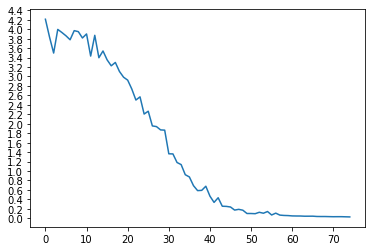

In [74]:
hidden_size = 256
encoder1 = EncoderRNN(train_input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, train_output_lang.n_words, dropout_p=0.1, MAX_LENGTH=25).to(device)

trainIters(encoder1, attn_decoder1, 7500, print_every=500)

It is good result. Let's check translation.

In [119]:
evaluateRandomly(encoder1, attn_decoder1, pairs=test_pairs, n=5)

> рече паки: аще которыи брать совершитъ довлѣясѧ трапезною пищею 
= и еще он сказал: если некии брат удовольствуется трапезнои пищеи 
< применяют вырезания и прижигания  чтобы <EOS>

> и въ ӡълое времѧ нихто емy не поможетъ 
= и в лихое время никто ему не поможет 
< веру властителями чтобы свои по тех чтобы <EOS>

> егда же оубиенъ бысть безбожныи батыи секирою богоданною отъ оугорьскаго краля владислава 
= когда же безбожныи батыи был убит богоданнои секирои венгерского короля владислава 
< растерзающии пелеи сведущии поняв что чтобы <EOS>

> или люди оправливати  или на ловъ ѣхати 
= или собираюсь творить суд между людеи  или ехать на охоту 
< многие обнажают души услышав это сведущии от чтобы <EOS>

> то падетьсѧ  тако и мyдрyѧ 
= то рухнет  как и тот  кто мудрствует 
< веру зорко умножились области чтобы суд верныи друг <EOS>



Tranclation is far from original.
Let's make traning with validation.

In [88]:
hidden_size = 256
encoder1 = EncoderRNN(train_input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, train_output_lang.n_words, dropout_p=0.1, MAX_LENGTH=25).to(device)

trainIters_val(encoder1, attn_decoder1, 7500, print_every=500)

1m 27s (- 20m 29s) (1 6%) 2.2089 6.7004
3m 3s (- 19m 54s) (2 13%) 0.0370 6.9512
4m 39s (- 18m 39s) (3 20%) 0.0118 7.4307
6m 16s (- 17m 15s) (4 26%) 0.0071 7.4153
7m 53s (- 15m 46s) (5 33%) 0.0051 7.6714
9m 31s (- 14m 16s) (6 40%) 0.0040 8.0668
11m 9s (- 12m 44s) (7 46%) 0.0033 8.1329
12m 48s (- 11m 12s) (8 53%) 0.0028 8.3115
14m 25s (- 9m 37s) (9 60%) 0.0024 8.3545
16m 2s (- 8m 1s) (10 66%) 0.0021 8.4968
17m 37s (- 6m 24s) (11 73%) 0.0019 8.7336
19m 13s (- 4m 48s) (12 80%) 0.0017 8.5439
20m 51s (- 3m 12s) (13 86%) 0.0015 8.4467
22m 27s (- 1m 36s) (14 93%) 0.0014 8.7386
24m 3s (- 0m 0s) (15 100%) 0.0013 8.5406


Model has decreasing loss for train sentences and increasing for test. That mean that model just learn train data and not improve translation.

Let's check translation results.

In [99]:
evaluateRandomly(encoder1, attn_decoder1, pairs=test_pairs, n=5)

> и съсѣщи главy невидимомy ӡмиеви 
= и отсечь главу невидимому змию 
< применяют вырезания и прижигания  чтобы <EOS>

> а вьсемъ людемъ пророкъ показасѧ 
= а всем людям явился пророком 
< применяют вырезания и прижигания  чтобы <EOS>

> аще къто не оумѣѧ кънигъ мyдрyеть 
= если некто  не разумея книг  мудрствует 
< применяют вырезания и прижигания  чтобы <EOS>

> пътицамъ бо того ради крилѣ данѣ  да сѣтеи человѣческихъ иӡбѣжатъ  а человѣкомъ къниги  яже вьсю неприяӡненy льсть обнажають 
= птицам для того даны два крыла  чтобы избежать человеческих сетеи  а людям – книги  которые обнажают весь дьявольскии обман
< применяют вырезания и прижигания  чтобы <EOS>

> аще кто не раӡсyдѧ собѧ и не смѣтѧ своего житья и промысла  и добытка 
= если кто-то  не рассудив своего положения и не рассчитав своего образа жизни  ремесла и доходов 
< применяют вырезания и прижигания  чтобы <EOS>



Look at attention. Choose 4 sentence to look.

input = господи  ты кто ѥси 
output = применяют вырезания и прижигания  чтобы <EOS>


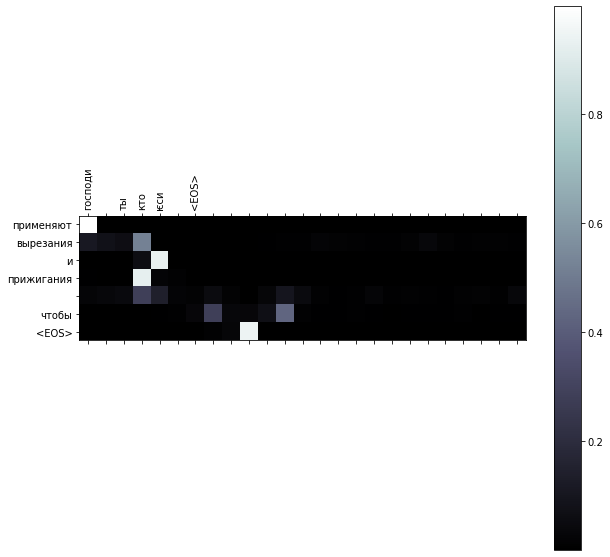

input = и въ ӡълое времѧ нихто емy не поможетъ 
output = применяют чтобы <EOS>


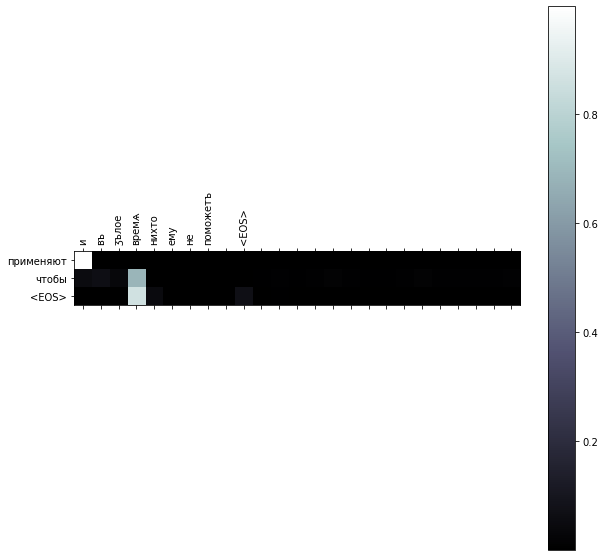

input = онъ же рече: отче  азъ много времѧ болѣзнию одержимъ и всегда молѧсѧ и призываѧ мyченика никитy 
output = применяют вырезания и прижигания  чтобы <EOS>


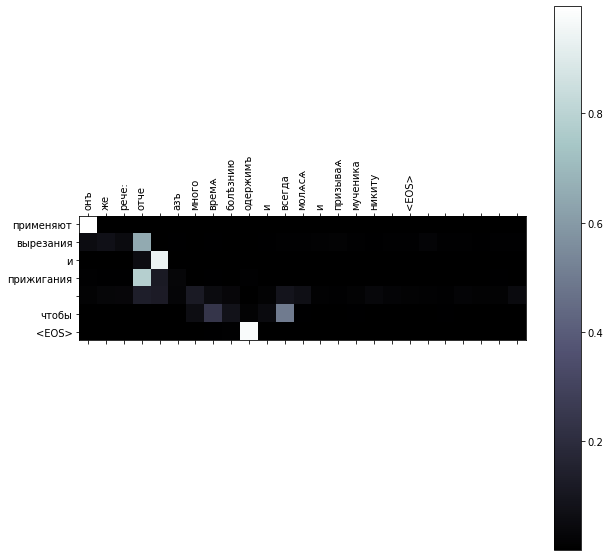

input = аще кто не раӡсyдѧ собѧ и не смѣтѧ своего житья и промысла  и добытка 
output = применяют вырезания и прижигания  чтобы <EOS>


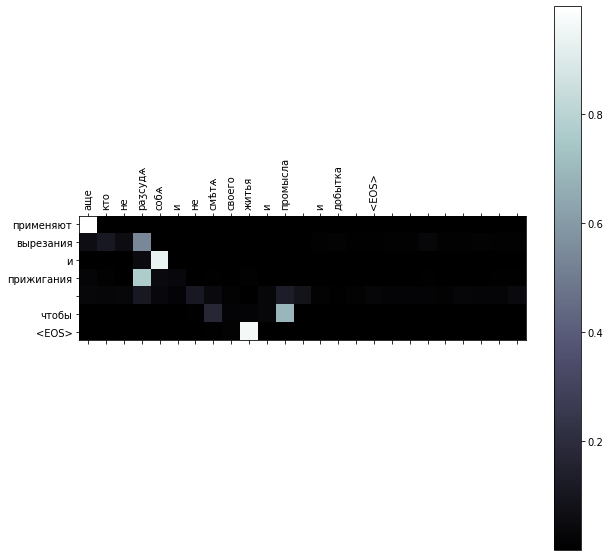

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention(test_pairs[35][0])
evaluateAndShowAttention(test_pairs[9][0])
evaluateAndShowAttention(test_pairs[15][0])
evaluateAndShowAttention(test_pairs[50][0])

There is no matches. Perhaps that is becouse the attention look at decoder inputs not at encoder outputs.

Let's try english-russian corpus.

In [19]:
#rus-eng
path='./rus.txt'

In [20]:
MAX_LENGTH=45

Upload data and make preprocessing

In [21]:
train_input_lang, train_output_lang, train_pairs, test_input_lang,\
           test_output_lang, test_pairs = prepareData('eng', 'rus', path, MAX_LENGTH=MAX_LENGTH, reverse=True)
print(random.choice(train_pairs))

Reading lines...
Read 308153 sentence pairs train
Read 132066 sentence pairs test
Trimmed to 308149 sentence train pairs
Trimmed to 132066 sentence test pairs
Counting words...
Counted words train:
eng 16380
rus 49826
Counted words test:
eng 12265
rus 34308
["tom didn't answer his phone ", 'том не снимал трубку ', 'cc-by 2 0 (france) attribution: tatoeba org #4529805 (ck) & #4724724 (marafon)']


Check len train pair

In [22]:
len_train=([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in train_pairs)
max(len_train)

[40, 39]

Check len test pair

In [156]:
len_test=([len(pair[0].split(' ')), len(pair[1].split(' '))] for pair in test_pairs)
max(len_test)

[43, 39]

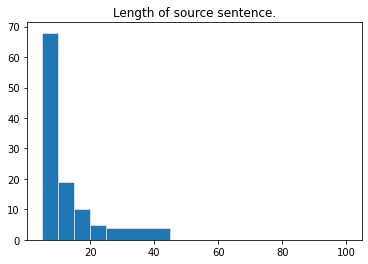

In [158]:
fig, ax = plt.subplots()
ax.hist(len_train_old, bins=[5, 10, 15, 20, 25, 45, 60, 100], linewidth=0.5, edgecolor="white")
plt.title('Length of source sentence.');



In [23]:
big_pair=[pair[0] for pair in train_pairs if len(pair[1].split(' '))>45]
len(big_pair)

0

Let's change max length of sentence to 45 and reapit preprocessing

In [24]:
hidden_size = 256
encoder1 = EncoderRNN(train_input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, train_output_lang.n_words, dropout_p=0.1, MAX_LENGTH=MAX_LENGTH).to(device)

trainIters_val(encoder1, attn_decoder1, 7500, print_every=500)

2m 16s (- 31m 44s) (1 6%) 5.1796 7.0689
4m 38s (- 30m 7s) (2 13%) 4.6480 8.2221
7m 2s (- 28m 9s) (3 20%) 4.3938 8.0905
9m 26s (- 25m 58s) (4 26%) 4.1396 8.2674
11m 52s (- 23m 44s) (5 33%) 4.0003 8.2369
14m 18s (- 21m 27s) (6 40%) 3.8658 8.7212
16m 43s (- 19m 7s) (7 46%) 3.7327 8.4464
19m 9s (- 16m 46s) (8 53%) 3.6601 8.5623
21m 35s (- 14m 23s) (9 60%) 3.6016 8.4552
24m 2s (- 12m 1s) (10 66%) 3.5171 8.6874
26m 27s (- 9m 37s) (11 73%) 3.4805 7.5791
28m 53s (- 7m 13s) (12 80%) 3.4394 8.5536
31m 21s (- 4m 49s) (13 86%) 3.3537 8.3827
33m 48s (- 2m 24s) (14 93%) 3.2950 8.9219
36m 14s (- 0m 0s) (15 100%) 3.2788 9.2126


The same situation as in smaller corpus 'old_slav'. Train loss is decreasing while validation loss is increasing.

In [26]:
evaluateRandomly(encoder1, attn_decoder1, train_pairs)

> do you like rice 
= ты любишь рис 
< кто кто не не не <EOS>

> tom said the soup was too hot 
= том сказал  что суп был слишком горячим 
< хорошее делается не не не не не не не <EOS>

> he had three sons 
= у него было трое сыновеи 
< кто кто кто не не <EOS>

> will you introduce me to her 
= ты меня с неи познакомишь 
< на не не не не не не <EOS>

> it's 3:30 
= сеичас полчетвертого 
< голову выиграю не <EOS>

> nobody knows how i feel 
= никто не знает  как я себя чувствую 
< делаешь неимоверно не не <EOS>

> just be careful with that 
= просто будьте с этим осторожны 
< поесть послал фотографию не не <EOS>

> you're in danger 
= ты в опасности 
< избежал не не не не <EOS>

> i want him to solve the problem 
= я хочу  чтобы он решил эту проблему 
< смог петь не не не не не <EOS>

> didn't i tell you not to do that anymore 
= разве я не говорила тебе больше не делать этого 
< среди не смог не не твои не не не не <EOS>



In [25]:
evaluateRandomly(encoder1, attn_decoder1, test_pairs)

> please speak louder 
= говори громче  пожалуиста 
< избежал не не не <EOS>

> she put her knitting aside and stood up 
= она отложила вязание и встала 
< узнать кто жди пошел не не не не не <EOS>

> you can't kill us all 
= ты не можешь убить нас всех 
< ворота не не тому тому не <EOS>

> tom remained silent all day 
= том молчал весь день 
< поверил тому тому тому не <EOS>

> we have exams right after summer vacation 
= сразу после летних каникул у нас экзамены 
< избежал не не не не не не <EOS>

> we're out of salt 
= у нас соль кончилась 
< выстрелом другои другои не не <EOS>

> i think you're too picky 
= по-моему  вы слишком придирчивы 
< смог полагаю не не не не <EOS>

> what station is it 
= что это за станция 
< дипломатична дипломатична дипломатична не не <EOS>

> some unexpected difficulties have arisen 
= возникли непредвиденные трудности 
< узнать кто не не не не <EOS>

> tom needs clothes 
= тому нужна одежда 
< через не не не <EOS>



input = my mother cut my hair too short 
output = швы швы не не не не не не не <EOS>


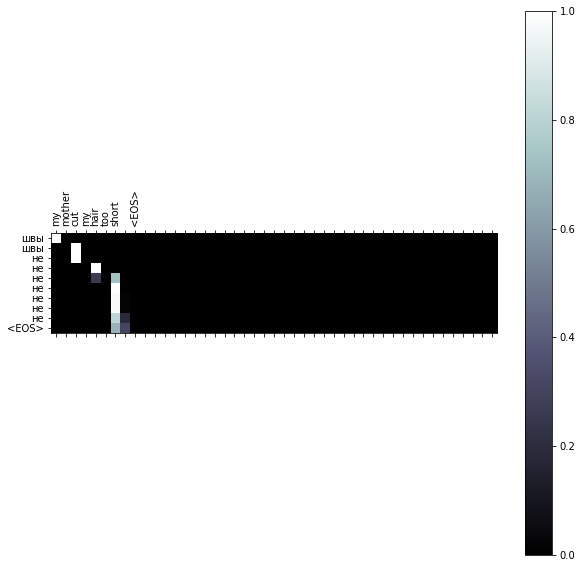

In [28]:
#attention

evaluateAndShowAttention(test_pairs[135][0])